In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
# from scipy.constants import h, c, k
from astropy import units as u
from astropy import constants as const

import bexrb_reflection as bexrb

from importlib import reload

import pandas as pd
from scipy.interpolate import CubicSpline
from scipy import integrate

import ogle_ref as o #module
from scipy.optimize import curve_fit
from astropy.table import Table,join,vstack,unique
    
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches    
    
blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

c1 = 'cornflowerblue'
c2 = 'navy'
c3 = 'rebeccapurple'
c4 = '#CF6275'
c5 = 'maroon'

import ultranest
from ultranest.plot import cornerplot
import ultranest.stepsampler
import corner

sigma_T=(const.sigma_T).cgs.value
sigma_SB=(const.sigma_sb).cgs.value
sigma_wien = 0.2897755
evtoerg = 1.6e-12
kpc_to_cm = 3.086e21
pc_to_cm = 3.086e18
A_to_cm = (u.angstrom).to(u.cm)


c=(const.c).cgs.value
k=(const.k_B).cgs.value
h=(const.h).cgs.value

In [2]:
RR = Table.read('DATA/results_flares.dat',format='ascii',names=['Lx','P','asini','I0','dm','F','eF', 'ext'])
RR

Lx,P,asini,I0,dm,F,eF,ext
float64,float64,float64,float64,float64,float64,float64,float64
4.0,23.97,105.0,14.415,0.13,0.112,0.01,0.0885
7.0,18.38,73.7,14.71,0.18,0.16,0.01,0.0735
25.0,45.07,189.0,14.73,0.32,0.25,0.01,0.066
1.8,20.0,100.0,15.518,0.13,0.098,0.005,0.144
20.0,27.7,115.5,11.2,0.26,0.213,0.02,1.9
1.3,17.13,142.4,15.946,0.33,0.279,0.014,0.114


In [3]:

# Given values
m_bg = 11.2          # Background magnitude
delta_I = 0.25        # Change in magnitude due to flare
# distance = 1e19      # Distance to the source in cm
distance =5*kpc_to_cm

m_bg = np.array(RR['I0']-RR['ext'])

delta_I = np.array(RR['F'])
delta_Ie = np.array(RR['F']-RR['eF'])
distance = np.array([50,60,60,60,5.2,60])*kpc_to_cm


# Reference flux for zero magnitude in the I-band (erg/s/cm^2/Å)
# F_0_I_band = 2.58e-10
F_0_I_band =112.6*1E-11 *7950

# F_0_I_band=1

# Compute background flux F_bg (in erg/s/cm^2/Å)
F_bg = F_0_I_band * 10**(-0.4 * m_bg)


# Compute flare flux F_flare (in erg/s/cm^2/Å)
F_flare = F_bg * (10**(0.4 * delta_I) - 1)
eF_flare = F_bg * (10**(0.4 * delta_Ie) - 1)

# Compute flare luminosity L_flare (in erg/s)
L_flare = 4 * np.pi * distance**2 * F_flare
eL_flare =L_flare- 4 * np.pi * distance**2 * eF_flare

# print(f"Flare Luminosity L_flare: {L_flare:.3e} erg/s")
print(m_bg)
print(F_bg*4 * np.pi * distance**2)
print(F_bg/np.min(F_bg))
print(L_flare/(F_bg*4 * np.pi * distance**2))
print('-----------')
print(L_flare)
# print(eL_flare/L_flare)
print(np.log10(eL_flare+L_flare) -np.log10(L_flare))

[14.3265 14.6365 14.664  15.374   9.3    15.832 ]
[4.98020518e+36 5.39026017e+36 5.25544781e+36 2.73281182e+36
 5.51968017e+36 1.79229597e+36]
[  4.00128974   3.00746097   2.93224328   1.52475477 410.01524051
   1.        ]
[0.10866414 0.15877736 0.25892541 0.09446027 0.2167462  0.29300439]
-----------
[5.41169707e+35 8.55851258e+35 1.36076899e+36 2.58142136e+35
 1.19636972e+36 5.25150590e+35]
[0.03883413 0.02812764 0.0189401  0.02252526 0.0423634  0.0238847 ]


Text(0.5, 0, '$\\log{L_X}\\,[ erg/s]$')

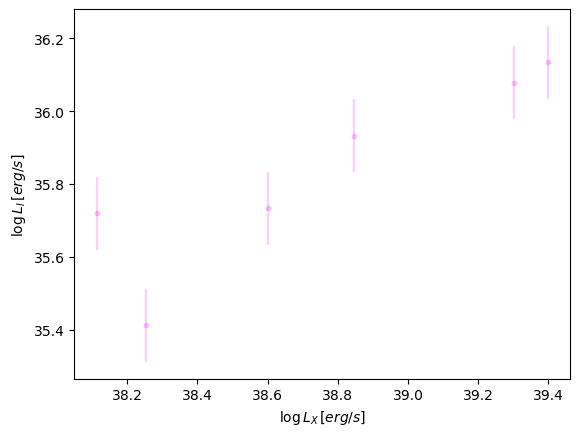

In [4]:
xx = np.log10(RR['Lx']*1E+38)
yy = np.log10(L_flare)
eyy = np.log10(eL_flare+L_flare) -np.log10(L_flare)

# eyy= np.sqrt(eyy0**2 + 0.05**2)

# plt.errorbar(xx,yy, yerr=eyy, fmt='.',color='magenta',alpha=0.2)
plt.errorbar(xx,yy, yerr=0.1, fmt='.',color='magenta',alpha=0.2)


plt.ylabel(r'$\log{L_I}\,[ erg/s]$')
plt.xlabel(r'$\log{L_X}\,[ erg/s]$')

In [5]:
param_names = ['A','B','$log(f)$']


def line(x, A, B):
    return A * x + B


def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = -10
    hi = 10
    # lo = 0.23
    # hi = 0.27
    params[0] = cube[0] * (hi - lo) + lo
    
    lo = -40
    hi = 40
    params[1] = cube[1] * (hi - lo) + lo
    
    lo = -10.0
    hi = 0.0
    params[2] = cube[2] * (hi - lo) + lo
    
    return params


def model(theta,x=xx):
    model = line(x,*theta)
    return model


def log_likelihood(params):
    ll =len(params)
    params1 = params[0:ll-1]
    log_f = params[ll-1]
    y_model = model(params1,xx)
#     sigma2 = yerr ** 2 + y_model ** 2 * np.exp(2 * log_f)
#     sigma2 = yerr ** 2 * np.exp(log_f)
    sigma2 = eyy ** 2 + np.exp(2 * log_f)
#     sigma2 =  eyyf** 2
    like = -0.5 * np.sum((yy - y_model) ** 2 / sigma2 + np.log(sigma2))
    return like


In [6]:
sampler0 = ultranest.ReactiveNestedSampler(param_names, log_likelihood, my_prior_transform,log_dir='ultranest_plane/run0',resume=True)

In [7]:
nsteps = 2 * len(param_names)
# create step sampler:
sampler0.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=nsteps)

# run again:
result0 = sampler0.run(min_num_live_points=400, max_num_improvement_loops=3) #,dlogz=0.5,frac_remain = 0.4) #607.904 to beat

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=1e+01  10.0324..10.0324]*| it/evals=7040/147491 eff=4.7862% N=400           0 0  0  0 0 0 0 
[ultranest] Likelihood function evaluations: 147747
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -2.94 +- 0.1486
[ultranest] Effective samples strategy satisfied (ESS = 2216.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.


In [8]:
print("Parameter means:", result0['posterior']['mean'])
print("Parameter standard deviations:", result0['posterior']['stdev'])


# Extract the posterior samples
posterior_samples = result0['samples']

# Define the parameter names
# param_names = ['A', 'B', '$log(f)$']

# Compute and print the 68% (one sigma) confidence intervals for each parameter
for i, param in enumerate(param_names):
    lower_bound = np.percentile(posterior_samples[:, i], 16)
    median = np.percentile(posterior_samples[:, i], 50)
    upper_bound = np.percentile(posterior_samples[:, i], 84)
    
    print(f"{param}: {median:.3f} (+{upper_bound - median:.3f}, -{median - lower_bound:.3f})")

    
text_lines = []
for i, param in enumerate(param_names):
    lower_bound = np.percentile(posterior_samples[:, i], 16)
    median = np.percentile(posterior_samples[:, i], 50)
    upper_bound = np.percentile(posterior_samples[:, i], 84)
    
    text_lines.append(f"{param}: {median:.3f}^{{+{upper_bound - median:.3f}}}_{{-{median - lower_bound:.3f}}}")

# Join the lines into a single string with newlines
text_str = '\n'.join(text_lines)

Parameter means: [0.4582904277947791, 18.07225408222304, -1.8722912983759572]
Parameter standard deviations: [0.15230834153653483, 5.898857656032345, 0.4001137679637985]
A: 0.454 (+0.134, -0.133)
B: 18.234 (+5.144, -5.247)
$log(f)$: -1.905 (+0.408, -0.357)



logZ = -2.957 +- 0.255
  single instance: logZ = -2.957 +- 0.166
  bootstrapped   : logZ = -2.940 +- 0.255
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A                   : -0.19 │ ▁▁▁▁▁▁▁▂▃▄▅▇▇▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁ ▁ │1.64      0.46 +- 0.15
    B                   : -27.5 │ ▁ ▁▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▇▇▇▅▄▃▂▁▁▁▁▁▁▁│40.0      18.1 +- 5.9
    $log(f)$            : -3.03 │ ▁▁▁▁▂▂▃▃▄▆▆▇▇▆▇▇▆▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁│-0.00     -1.87 +- 0.40



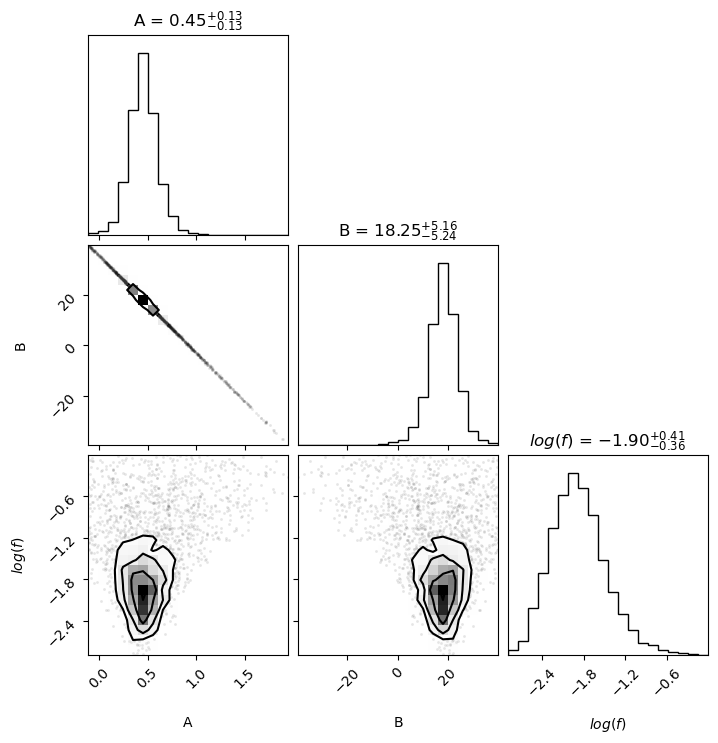

In [9]:
sampler0.print_results()
cornerplot(result0)

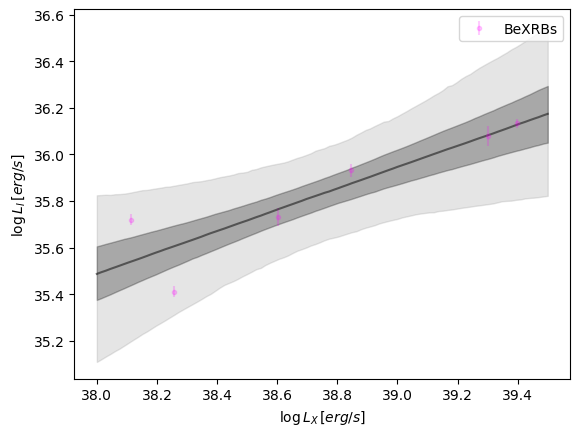

In [10]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')

eyy2 = np.sqrt(eyy**2 + np.exp(2 * -1.93))

# plt.errorbar(np.log10(RR['Lx']),RR['F'], yerr=RR['eF'], fmt='o',color='magenta',label='Flare')
plt.errorbar(xx,yy, yerr=eyy, fmt='.',color='magenta',alpha=0.2,label='BeXRBs')


t_grid = np.linspace(38,39.5, 100)


from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for A,B,logf in sampler0.results['samples']:
    # compute for each time the y value
    theta=[A,B]
    band.add(model(theta,t_grid))

band.line(color='k',alpha=0.5)
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

plt.ylabel(r'$\log{L_I}\,[ erg/s]$')
plt.xlabel(r'$\log{L_X}\,[ erg/s]$')


plt.legend()

## model

In [14]:
# Parameters
Rsun = 6.96E+10  # Solar radius in cm
star_radius = 8 * Rsun
num_points = 100
# point_source_distance = 108/115 * 3.4477e12  # Distance in cm (115 light-seconds)
# point_source_distance = 5E+12
point_source_distance = 64*Rsun
T0_star = 30000  # Initial temperature in Kelvin
T0_disk = 30000  # Initial temperature in Kelvin
L = 2E+39  # Luminosity in erg/s
inner_disk_radius = 1.001 * star_radius  # Inner radius of the disk
outer_disk_radius = 5.5 * star_radius  # Outer radius of the disk
inclination_angle_y = 45.0  # Inclination angle in degrees
inclination_angle_z = 0

30000


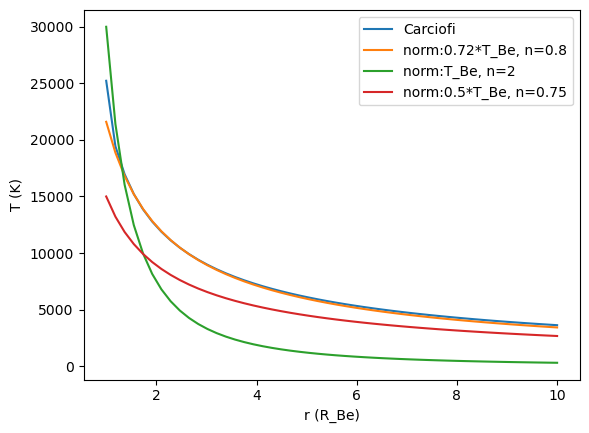

In [15]:
r = np.linspace(1.,10)
Tc = bexrb.temp_Carciofi(r, 1, T0_star)
Td = 0.72*T0_star * (r / 1)**(-0.8)
Td1 = T0_star * (r / 1)**(-2)
Td2 = 0.5*T0_star * (r / 1)**(-0.75)

plt.plot(r,Tc, label='Carciofi')
plt.plot(r,Td, label='norm:0.72*T_Be, n=0.8')
plt.plot(r,Td1, label='norm:T_Be, n=2')
plt.plot(r,Td2, label='norm:0.5*T_Be, n=0.75')
plt.legend()
plt.xlabel('r (R_Be)')
plt.ylabel('T (K)')
print(T0_star)

In [16]:
par00 = np.linspace(38,39.5,10)
par1 = 10**par00

xmin = 7.4e-5
xmax = 8.7e-5

flares0 = []
T0_star = 30000  # Initial temperature in Kelvin
T0_disk = T0_star*0.6  # Initial temperature in Kelvin
inner_disk_radius = 1.001 * star_radius 
outer_disk_radius = 5.5 * star_radius
inclination_angle_y = 45.0 

for i in range(par1.shape[0]):
    L = par1[i]
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=2, en='W')
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W',Carciofi=True)
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares0.append(integral)

compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi


In [17]:
T0_disk = T0_star*0.6
flares01 = []
for i in range(par1.shape[0]):
    L = par1[i]
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W',Carciofi=True)
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares01.append(integral)
    
flares02 = []
for i in range(par1.shape[0]):
    L = par1[i]
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=1., en='W',Carciofi=True)
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares02.append(integral)
    
flares03 = []
for i in range(par1.shape[0]):
    L = par1[i]
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.75, n=1.0, en='W',Carciofi=True)
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares03.append(integral)

compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carciofi
compute Carcio

In [21]:
D =50*kpc_to_cm

par01 = np.linspace(36,42,20)
par1 = 10**par01

xmin = 7.4e-5
xmax = 8.7e-5

flares01 = []
flares01no = []

I_arr = []
V_arr = []
VI_arr = []
# flares.append(2)
inner_disk_radius = 1.001* star_radius
outer_disk_radius = 5.5 * star_radius
inclination_angle_y = 45.0 

for i in range(par1.shape[0]):
    print(i)
    L = par1[i]
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=2, en='W',Carciofi=False)
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W',Carciofi=True)
    
    # mag_V_sys0, mag_I_sys0, color_VI_sys0 = bexrb.col_mag(wave,sed_Star0/(4*np.pi *D**2)+sed_disk0/(2*np.pi*D**2) )
    mag_V_sys, mag_I_sys, color_VI_sys = bexrb.col_mag(wave,sed_Star0/(4*np.pi *D**2)+sed_disk/(2*np.pi*D**2) )
    I_arr.append(mag_I_sys)
    V_arr.append(mag_V_sys)
    VI_arr.append(color_VI_sys)
    XX = wave
    YY = sed_disk
    YY0 = sed_disk0
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    Y_integration = YY0[mask]
    # Perform the integration using the trapezoidal rule
    integral0 = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares01.append(integral)
    flares01no.append(integral-integral0)

0
compute Carciofi
compute Carciofi
1
compute Carciofi
compute Carciofi
2
compute Carciofi
compute Carciofi
3
compute Carciofi
compute Carciofi
4
compute Carciofi
compute Carciofi
5
compute Carciofi
compute Carciofi
6
compute Carciofi
compute Carciofi
7
compute Carciofi
compute Carciofi
8
compute Carciofi
compute Carciofi
9
compute Carciofi
compute Carciofi
10
compute Carciofi
compute Carciofi
11
compute Carciofi
compute Carciofi
12
compute Carciofi
compute Carciofi
13
compute Carciofi
compute Carciofi
14
compute Carciofi
compute Carciofi
15
compute Carciofi
compute Carciofi
16
compute Carciofi
compute Carciofi
17
compute Carciofi
compute Carciofi
18
compute Carciofi
compute Carciofi
19
compute Carciofi
compute Carciofi


In [22]:
coefficients = np.polyfit(par00, np.log10(flares0), 1)
# coefficients = np.polyfit(par01, np.log10(flares01), 1)
m, b = coefficients
m,b

(0.30599536866909316, 24.220212732245866)

In [23]:
par011 = np.linspace(36,42,20)
par1 = 10**par011

xmin = 7.4e-5
xmax = 8.7e-5

flares011 = []
# flares.append(2)
inner_disk_radius = 1.001* star_radius
outer_disk_radius = 5.5 * star_radius
inclination_angle_y = 10.0 
# inclination_angle_y = 45.0 

for i in range(par1.shape[0]):
    print(i)
    L = par1[i]
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=2, en='W')
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.7, n=0.75, en='W')
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W')
    
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares011.append(integral)

0
compute Carciofi
compute Carciofi
1
compute Carciofi
compute Carciofi
2
compute Carciofi
compute Carciofi
3
compute Carciofi
compute Carciofi
4
compute Carciofi
compute Carciofi
5
compute Carciofi
compute Carciofi
6
compute Carciofi
compute Carciofi
7
compute Carciofi
compute Carciofi
8
compute Carciofi
compute Carciofi
9
compute Carciofi
compute Carciofi
10
compute Carciofi
compute Carciofi
11
compute Carciofi
compute Carciofi
12
compute Carciofi
compute Carciofi
13
compute Carciofi
compute Carciofi
14
compute Carciofi
compute Carciofi
15
compute Carciofi
compute Carciofi
16
compute Carciofi
compute Carciofi
17
compute Carciofi
compute Carciofi
18
compute Carciofi
compute Carciofi
19
compute Carciofi
compute Carciofi


In [26]:
par0111 = np.linspace(36,42,20)
par1 = 10**par0111

xmin = 7.4e-5
xmax = 8.7e-5

flares0111 = []
# flares.append(2)
inner_disk_radius = 1.001* star_radius
outer_disk_radius = 7.5 * star_radius
inclination_angle_y = 45.0 

for i in range(par1.shape[0]):
    print(i)
    L = par1[i]
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=2, en='W')
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W')
    
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares0111.append(integral)

0
compute Carciofi
compute Carciofi
1
compute Carciofi
compute Carciofi
2
compute Carciofi
compute Carciofi
3
compute Carciofi
compute Carciofi
4
compute Carciofi
compute Carciofi
5
compute Carciofi
compute Carciofi
6
compute Carciofi
compute Carciofi
7
compute Carciofi
compute Carciofi
8
compute Carciofi
compute Carciofi
9
compute Carciofi
compute Carciofi
10
compute Carciofi
compute Carciofi
11
compute Carciofi
compute Carciofi
12
compute Carciofi
compute Carciofi
13
compute Carciofi
compute Carciofi
14
compute Carciofi
compute Carciofi
15
compute Carciofi
compute Carciofi
16
compute Carciofi
compute Carciofi
17
compute Carciofi
compute Carciofi
18
compute Carciofi
compute Carciofi
19
compute Carciofi
compute Carciofi


In [24]:
par04 = np.linspace(36,42,20)
par4 = 10**par04

xmin = 7.4e-5
xmax = 8.7e-5

flares04 = []
I_arr = []
V_arr = []
VI_arr = []
# flares.append(2)

inner_disk_radius = 2.001* star_radius
outer_disk_radius = 5.5 * star_radius
inclination_angle_y = 45.0 

for i in range(par4.shape[0]):
    print(i)
    L = par4[i]
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=2, en='W',Carciofi=False)
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W',Carciofi=True)
    
    # mag_V_sys0, mag_I_sys0, color_VI_sys0 = bexrb.col_mag(wave,sed_Star0/(4*np.pi *D**2)+sed_disk0/(2*np.pi*D**2) )
    mag_V_sys, mag_I_sys, color_VI_sys = bexrb.col_mag(wave,sed_Star0/(4*np.pi *D**2)+sed_disk/(2*np.pi*D**2) )
    I_arr.append(mag_I_sys)
    V_arr.append(mag_V_sys)
    VI_arr.append(color_VI_sys)
    XX = wave
    YY = sed_disk
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares04.append(integral)

0
compute Carciofi
compute Carciofi
1
compute Carciofi
compute Carciofi
2
compute Carciofi
compute Carciofi
3
compute Carciofi
compute Carciofi
4
compute Carciofi
compute Carciofi
5
compute Carciofi
compute Carciofi
6
compute Carciofi
compute Carciofi
7
compute Carciofi
compute Carciofi
8
compute Carciofi
compute Carciofi
9
compute Carciofi
compute Carciofi
10
compute Carciofi
compute Carciofi
11
compute Carciofi
compute Carciofi
12
compute Carciofi
compute Carciofi
13
compute Carciofi
compute Carciofi
14
compute Carciofi
compute Carciofi
15
compute Carciofi
compute Carciofi
16
compute Carciofi
compute Carciofi
17
compute Carciofi
compute Carciofi
18
compute Carciofi
compute Carciofi
19
compute Carciofi
compute Carciofi


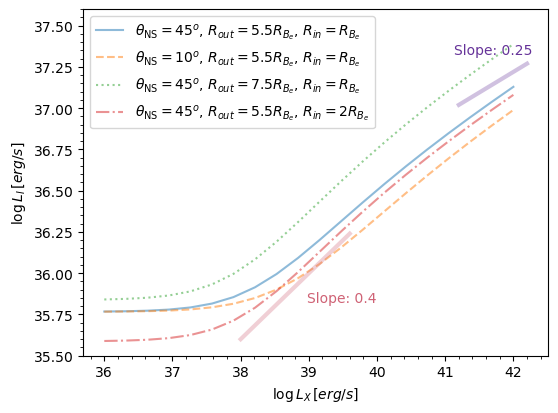

In [27]:
fig = plt.figure(figsize=(6, 4.5))
# plt.plot(par00,np.log10(flares0),'.')
plt.plot(par01,np.log10(flares01),'-',alpha=0.5,label=r'$\theta_{\rm NS}=45^o$, $R_{out}=5.5R_{B_e}$, $R_{in}=R_{B_e}$')
# plt.plot(par01,np.log10(flares01no),'-',alpha=0.5,label=r'no')
# plt.plot(par00, np.log10(flares0),'o')
plt.plot(par011,np.log10(flares011),'--',alpha=0.5,label=r'$\theta_{\rm NS}=10^o$, $R_{out}=5.5R_{B_e}$, $R_{in}=R_{B_e}$')

plt.plot(par0111,np.log10(flares0111),':',alpha=0.5,label=r'$\theta_{\rm NS}=45^o$, $R_{out}=7.5R_{B_e}$, $R_{in}=R_{B_e}$')

plt.plot(par04,np.log10(flares04),ls='dashdot',alpha=0.5,label=r'$\theta_{\rm NS}=45^o$, $R_{out}=5.5R_{B_e}$, $R_{in}=2R_{B_e}$')
x_grid = np.linspace(38,39.6, 10)
# x_grid = np.linspace(36,41, 10)
y_grid = b+x_grid*m
# y_grid = b+x_grid*0.458
# y_grid = 18.3+x_grid*0.458
y_grid = 20.4+x_grid*0.4


x_grid2 = np.linspace(41.2,42.2, 10)
y_grid2 = b+x_grid2*0.25 +2.5#+7.1
# y_grid2 = b+x_grid2*0.25 +1.55#+7.1

plt.plot(x_grid,y_grid,'-', color=c4,alpha=0.3,linewidth=3)
plt.plot(x_grid2,y_grid2,'-',color=c3,alpha=0.3,linewidth=3)

# plt.text(38.45, 36.15, f"Slope: {m:.2f}",
#          horizontalalignment='right', verticalalignment='center', color=c4)

plt.text(40., 35.85, f"Slope: 0.4",
         horizontalalignment='right', verticalalignment='center', color=c4)

plt.text(42.28, 37.35, f"Slope: 0.25",
         horizontalalignment='right', verticalalignment='center', color=c3)

plt.ylabel(r'$\log{L_I}\,[ erg/s]$')
plt.xlabel(r'$\log{L_X}\,[ erg/s]$')

plt.minorticks_on()

plt.ylim(35,38)
plt.ylim(35.5,37.6)
plt.legend()

# bexrb.sf('Plane_trend_Car')

In [28]:
par0 = np.linspace(37.5,39.5,4)
# par0 = np.linspace(36,42,20)
NN=200
par02 = np.random.uniform(38,39.5, NN)
par1 = 10**par02
par2 = np.random.uniform(5,90, NN)
# par3 = np.random.uniform(3,7, NN)* star_radius
par3 = np.random.uniform(4,9, NN)* star_radius

par4 = np.random.uniform(1.001,2.001, NN)* star_radius


# Generate uniform random numbers between 0 and 1
uniform_randoms = np.random.rand(NN)
# Transform to inclination angles using the inverse CDF method
random_inclinations = np.arccos(1 - uniform_randoms)
par5 = np.degrees(random_inclinations)

xmin = 7.4e-5
xmax = 8.7e-5

flares2 = []
flares3 = []
# flares.append(2)
inner_disk_radius = 2.001 * star_radius
outer_disk_radius = 5.5 * star_radius
inclination_angle_y = 45.0 
inner_disk_radius = 1.001
for i in range(par1.shape[0]):
    print(i)
    L = par1[i]
    inclination_angle_y = par2[i]
    outer_disk_radius = par3[i]
    inner_disk_radius = par4[i]
    # wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=2, en='W')
    wave, sed_Star0, sed_disk0, sed_disk = bexrb.sed_build(star_radius, num_points, point_source_distance, T0_star, L, inner_disk_radius, outer_disk_radius, inclination_angle_y, inclination_angle_z, T0_disk, albedo=0.5, n=0.75, en='W')
    XX = wave
    YY = sed_disk
    YY0 = sed_disk0
    mask = (XX >= xmin) & (XX <= xmax)
    # Apply the mask to select relevant points
    X_integration = XX[mask]
    Y_integration = YY[mask]
    # Perform the integration using the trapezoidal rule
    integral = np.trapz(Y_integration*X_integration, np.log(X_integration))
    Y_integration = YY0[mask]
    # Perform the integration using the trapezoidal rule
    integral0 = np.trapz(Y_integration*X_integration, np.log(X_integration))
    flares2.append(integral)
    flares3.append(integral-integral0)

0
compute Carciofi
compute Carciofi
1
compute Carciofi
compute Carciofi
2
compute Carciofi
compute Carciofi
3
compute Carciofi
compute Carciofi
4
compute Carciofi
compute Carciofi
5
compute Carciofi
compute Carciofi
6
compute Carciofi
compute Carciofi
7
compute Carciofi
compute Carciofi
8
compute Carciofi
compute Carciofi
9
compute Carciofi
compute Carciofi
10
compute Carciofi
compute Carciofi
11
compute Carciofi
compute Carciofi
12
compute Carciofi
compute Carciofi
13
compute Carciofi
compute Carciofi
14
compute Carciofi
compute Carciofi
15
compute Carciofi
compute Carciofi
16
compute Carciofi
compute Carciofi
17
compute Carciofi
compute Carciofi
18
compute Carciofi
compute Carciofi
19
compute Carciofi
compute Carciofi
20
compute Carciofi
compute Carciofi
21
compute Carciofi
compute Carciofi
22
compute Carciofi
compute Carciofi
23
compute Carciofi
compute Carciofi
24
compute Carciofi
compute Carciofi
25
compute Carciofi
compute Carciofi
26
compute Carciofi
compute Carciofi
27
compute 

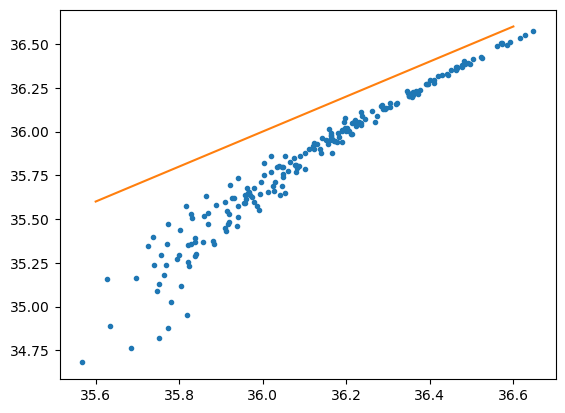

In [29]:
plt.plot(np.log10(flares2),np.log10(flares3),'.')
plt.plot(np.array([35.6,36.6]),np.array([35.6,36.6]),'-')

(38.0, 39.5)

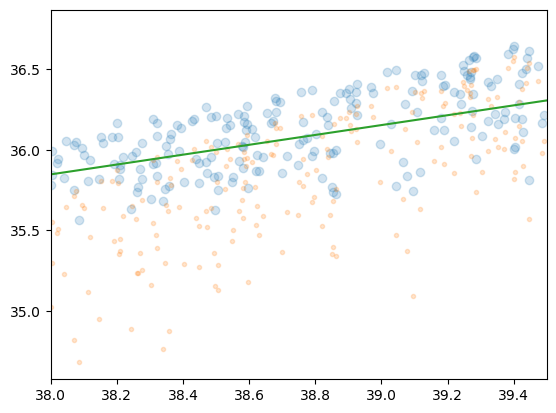

In [30]:
plt.plot(par02,np.log10(flares2),'o',alpha=0.2)
plt.plot(par02,np.log10(flares3),'.',alpha=0.2)
# x_grid = np.linspace(38,39.5, 10)
x_grid = np.linspace(36,41, 10)
y_grid = b+x_grid*m
plt.plot(x_grid,y_grid)

plt.xlim(38,39.5)

In [31]:
text_str

'A: 0.454^{+0.134}_{-0.133}\nB: 18.234^{+5.144}_{-5.247}\n$log(f)$: -1.905^{+0.408}_{-0.357}'

In [32]:
# text_str2 = '$Slope: 0.46^{+0.13}_{-0.13}$ \n$Offset: 18^{+5}_{-5}$ \n$log(f): -1.9^{+0.4}_{-0.3}$'
text_str2 = '$Slope: 0.458^{+0.13}_{-0.13}$ \n$Offset: 18^{+5}_{-5}$ \n$log(f): -1.9^{+0.4}_{-0.3}$'

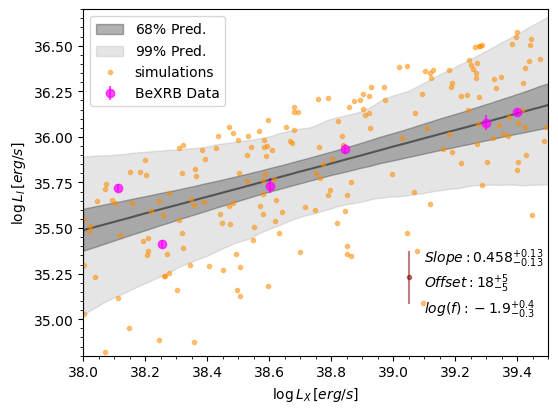

In [33]:

fig = plt.figure(figsize=(6, 4.5))
plt.xlabel('x')
plt.ylabel('y')
# plt.errorbar(x=xx2, y=yy, yerr=eyy,
#              marker='o', ls=' ', color='orange')

# plt.plot(np.log10(RR['Lx']),RR['dm'],'.k',label =r'$\Delta mag$')
# plt.errorbar(np.log10(RR['Lx'][-1]),RR['F'][-1], yerr=RR['eF'][-1], fmt='.',color='magenta')

eyy2 = np.sqrt(eyy**2 + np.exp(2 * -1.93))

# plt.errorbar(np.log10(RR['Lx']),RR['F'], yerr=RR['eF'], fmt='o',color='magenta',label='Flare')
plt.errorbar(xx,yy, yerr=eyy, fmt='o',color='magenta',alpha=0.7,label='BeXRB Data')


t_grid = np.linspace(38,39.5, 100)


from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for A,B,logf in sampler0.results['samples']:
    # compute for each time the y value
    theta=[A,B]
    band.add(model(theta,t_grid))

band.line(color='k',alpha=0.5)
# add 1 sigma quantile
band.shade(color='k', alpha=0.3,label=r'68$\%$ Pred.')
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.495, color='gray', alpha=0.2,label=r'99$\%$ Pred.')

plt.ylabel(r'$\log{L_I}\,[ erg/s]$')
plt.xlabel(r'$\log{L_X}\,[ erg/s]$')

x_grid = np.linspace(38,39.5, 10)
y_grid = b+x_grid*m
# plt.plot(x_grid,y_grid,label='Sim. slope 0.43',color=c4)
# plt.plot(x_grid,y_grid,label=f"Sim. slope {m:.2f}",color=c4)

# plt.plot(par02,np.log10(flares2),'.',alpha=0.5,label='simulations',color='darkorange')
plt.plot(par02,np.log10(flares3),'.',alpha=0.5,label='simulations',color='darkorange')


plt.text(39.1, 35.4, text_str2, fontsize=10, verticalalignment='top')

plt.xlim(38,39.5)
plt.ylim(34.8,36.7)
plt.minorticks_on()

# plt.errorbar(39.05,35.23, yerr=np.sqrt(np.exp(2 * -1.93)), fmt='.',color=c5,alpha=0.5,label=r'scatter - $\log{f}$')
plt.errorbar(39.05,35.23, yerr=np.sqrt(np.exp(2 * -1.93)), fmt='.',color=c5,alpha=0.5)


plt.legend(loc=2)

o.sf('Data_Sim_Cor')